<a href="https://colab.research.google.com/github/anuragk24/ak24/blob/master/FeedForwardNeuralNetwork-MCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as clrs 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder

#General Class

In [32]:
class FFSNNetwork:
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    self.W = {}
    self.B = {}
    self.loss  = None

    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)

    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    
    return self.H[self.nh + 1]

  def grad_sigmoid(self, x):
    return x*(1-x) 
    
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    #initialise w,b
    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))

    if display_loss:
      loss = {}

    for e in tqdm_notebook(range(epochs), total=epochs, unit='Epoch'):
      dW = {}
      dB = {}

      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))

      for x,y in zip(X,Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]

      m = X.shape[1]
      for i in range(self.nh + 1):
        self.W[i+1] -= learning_rate*dW[i+1] / m
        self.B[i+1] -= learning_rate*dB[i+1] / m

      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      self.loss = loss
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      plt.grid()
      plt.ylabel('Mean squared error')
      plt.show()


  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
        
    return np.array(Y_pred).squeeze()


#Blobs data

In [33]:
my_cmap = clrs.LinearSegmentedColormap.from_list('',['red','green','blue'])

In [34]:
data, labels = make_blobs(n_samples=2000, n_features=2, centers=4, random_state=0)
print(data.shape, labels.shape)

(2000, 2) (2000,)


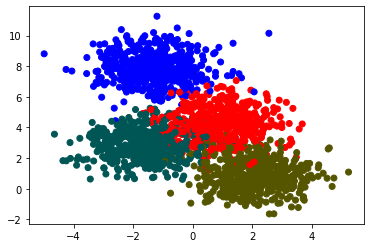

In [35]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=my_cmap)
plt.show()

In [36]:
labels_org = labels
labels = np.mod(labels_org, 2)

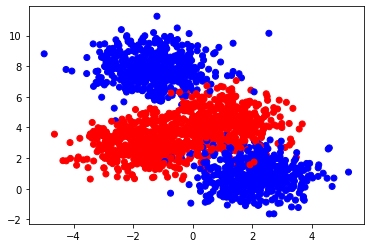

In [37]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=my_cmap)
plt.show()

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_org, stratify=labels_org, random_state=0)
print(X_train.shape, X_val.shape)

(1500, 2) (500, 2)


In [42]:
enc = OneHotEncoder()
y_oh_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
y_oh_val =enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()

In [61]:
ffn=FFSNNetwork(2, 4, [5, 5, 8])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


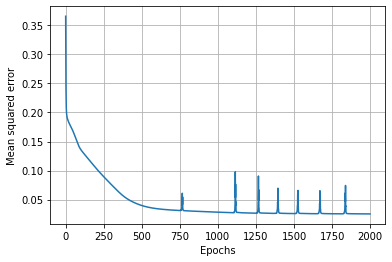

In [66]:
ffn.fit(X_train, y_oh_train, epochs=2000, learning_rate=0.0005, display_loss=True)

0.9326666666666666 0.93


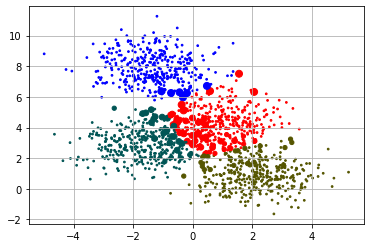

In [67]:
Y_pred_train = ffn.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train, 1)
Y_pred_val = ffn.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val, 1)
train_accuracy = accuracy_score(Y_train, Y_pred_train)
val_accuracy = accuracy_score(Y_val, Y_pred_val)

print(train_accuracy, val_accuracy)

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(Y_pred_train-Y_train)+0.2))
plt.grid()
plt.show()